# COSC 4610/5610 Project 3 (Spring 2022)

**Author:** Carl Barcenas \
**Email:** carlanthony.barcenas@marquette.edu

## Task 0: Set Up Environment

In [1]:
import sklearn as sk
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import os, sys
import matplotlib.pyplot as plt
import math

## Task 1: Find the Best Classifier for mini_newsgroup data
* Multinomial
* Bernoulli NB
* kNN
* SVM

#### Task 1 Prelim: Load Libraries and Data

In [2]:
from sklearn.model_selection import cross_val_score # Evaluation Tool
from sklearn.datasets import load_svmlight_file # Loads svm files

feature_vectors, targets = load_svmlight_file('tfidf_train.txt')

#### Task 1.1 Feature normalization on kNN and SVC
In this section, we apply max-min normalization to find out how normalization may affect the classifier performance.

In [3]:
# First, create Feature Normalized Data
from sklearn.preprocessing import MaxAbsScaler
transformer = MaxAbsScaler().fit(feature_vectors)
X_new = transformer.transform(feature_vectors)

# Set up KNN, 1 neighbors
from sklearn.neighbors import KNeighborsClassifier # Load kNN classifier
knn_clf = KNeighborsClassifier(n_neighbors = 1) # Create kNN classifier instance

# Set up SVC
from sklearn.svm import SVC # Load SVC classifier
svc_clf = SVC() # Create SVC classifier instance

# Calculate cross validation score for both non-normalized and normalized
# data sets and for both kNN and SVC using cross_val_score function
knn_scores = cross_val_score(knn_clf, feature_vectors, targets, # KNN non-norm
                             cv=5, scoring='f1_macro') 
knn_scores_norm = cross_val_score(knn_clf, X_new, targets, # KNN norm
                                 cv=5, scoring='f1_macro')

svc_scores = cross_val_score(svc_clf, feature_vectors, targets, # SVC non-norm
                            cv=5, scoring='f1_macro')
svc_scores_norm = cross_val_score(svc_clf, X_new, targets, # SVC Norm
                                cv=5, scoring='f1_macro')

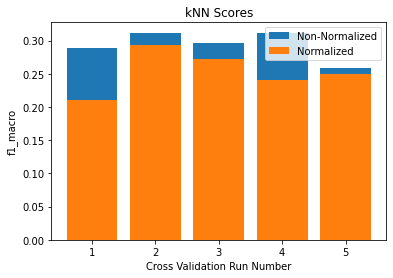

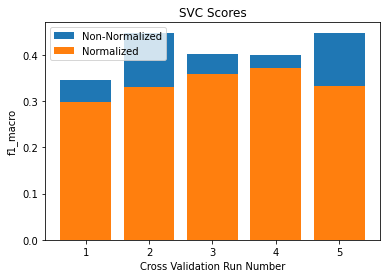

In [4]:
# Plotting results in a bar graph for KNN
plt.figure() # initialize plot
x_array = [1, 2, 3, 4, 5] # initiate x array for each run of cross validation
plt.bar(x_array, knn_scores, label = "Non-Normalized") # plot non-normalized results
plt.bar(x_array, knn_scores_norm, label = "Normalized") # plot normalized results
plt.xlabel("Cross Validation Run Number")
plt.ylabel("f1_macro")
plt.title("kNN Scores")
plt.legend()
plt.show()

# Plotting results in a bar graph for SVC
plt.figure()
x_array = [1, 2, 3, 4, 5]
plt.bar(x_array, svc_scores, label = "Non-Normalized")
plt.bar(x_array, svc_scores_norm, label = "Normalized")
plt.xlabel("Cross Validation Run Number")
plt.ylabel("f1_macro")
plt.title("SVC Scores")
plt.legend()
plt.show()

As seen from the bar graphs above, it appears that normalization actually negatively impacted my training data as for all runs of cross validation the non-normalized score is higher than the normalized score for both classifiers. Thus, I will continue to use non-normalized data.

#### Task 1.2: Hyperparameter tuning for kNN
We try to find the best n_neighbors to initialize a kNN classifier with from 1 to 20.

In [5]:
"""
Function to calculate a sample's confidence interval.
Obtained from stackoverflow
"""
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

Text(0.5, 1.0, 'KNN Cross Validation Score vs. Number of Neighbors')

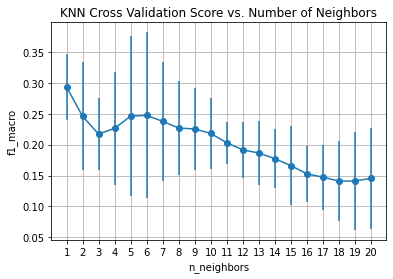

In [6]:
scores = [] # List to hold cross-val scores for each run
conf_int_low = [] # lists to hold lower and higher end of confidence interval
conf_int_high = []
neighbors = np.arange(1, 21) # array of values for knn neighbor number (1 to 20)

# Loop to calculate cross val score for all neighbor counts
for i in neighbors:
    # initialize knn classifier with different n_neighbors per iteration
    knn_clf = KNeighborsClassifier(n_neighbors = i)
    
    # calculate cross validation scores
    iteration = cross_val_score(knn_clf, feature_vectors, targets,
                             cv=5, scoring='f1_macro')
    
    # find mean and confidence intervals using function above
    m, c_low, c_high = mean_confidence_interval(iteration)
    
    # append to respective lists
    scores.append(m)
    conf_int_low.append(c_low)
    conf_int_high.append(c_high)

# Create dataframe for plotting process (in order to apply confidence interval
# as error bars)
d = {'index': neighbors, 'mean': scores, 
     'c_low': conf_int_low, 'c_high': conf_int_high}
df = pd.DataFrame(data=d)
    
# Plot scores and confidence intervals 
plt.figure()
plt.errorbar(df['index'], df['mean'], yerr=(df['c_high']-df['c_low']), 
             marker='o')
plt.xticks(neighbors)
plt.grid()
plt.xlabel("n_neighbors")
plt.ylabel("f1_macro")
plt.title('KNN Cross Validation Score vs. Number of Neighbors')

As seen from the plot above, the best option for the kNN classifier is to use n_neighbors = 1 as it has the highest cross validation score. Thus, for the remainder of this assignment I will strictly use n_neighbors=1 for kNN.

#### Task 1.3: Best Classifier
After optimizing the classifiers that needed optimization, this section will then compare all of the classifiers and identify the top 2.

Text(0.5, 1.0, 'Plot of f1_macro vs. Classifier')

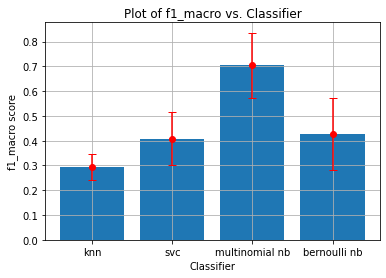

In [7]:
# Note: Optimal knn and SVC f1_macro scores are already stored in 'knn_scores'
# and 'svc_scores' due to not needing to normalize or change n_neighbors

# Set Up Multinomial and Bernoulli Naive Bayes Classifiers
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
multinomial_clf = MultinomialNB()
bernoulli_clf = BernoulliNB()

# Calculate cross validation score for both multinomial and bernoulli nb classifiers
multinomial_scores = cross_val_score(multinomial_clf, feature_vectors, targets,
                             cv=5, scoring='f1_macro')
bernoulli_scores = cross_val_score(bernoulli_clf, feature_vectors, targets,
                             cv=5, scoring='f1_macro')

# Get all classifiers's mean and confidence intervals using function from 1.2
knn_m, knn_c_low, knn_c_high = mean_confidence_interval(knn_scores)
svc_m, svc_c_low, svc_c_high = mean_confidence_interval(svc_scores)
mult_m, mult_c_low, mult_c_high = mean_confidence_interval(multinomial_scores)
bern_m, bern_c_low, bern_c_high = mean_confidence_interval(bernoulli_scores)

# Place all means and confidence intervals into lists for plotting
classifier = ['knn', 'svc', 'multinomial nb', 'bernoulli nb']
scores = [knn_m, svc_m, mult_m, bern_m]
conf_int = [[knn_c_low, knn_c_high], [svc_c_low, svc_c_high],
            [mult_c_low, mult_c_high], [bern_c_low, bern_c_high]]
yerr = [(knn_c_high-knn_c_low) , (svc_c_high-svc_c_low) ,
            (mult_c_high-mult_c_low) , (bern_c_high-bern_c_low)]

# Plot data
plt.figure()
plt.bar(classifier, scores)
plt.errorbar(
    classifier,
    scores,
    yerr = yerr,
    fmt='o',
    capsize=4,
    color='red'
)
plt.grid()
plt.xlabel('Classifier')
plt.ylabel('f1_macro score')
plt.title('Plot of f1_macro vs. Classifier')

From this plot we can see that Multinomial Naive Bayes is the highest scorer of all classifiers with Bernoulli Naive Bayes just narrowly beating SVC for 2nd place. Thus, we apply t-tests for Multinomial and Bernoulli NB

In [8]:
# Perform a t-test on Bernoulli and Multinomial Classifiers
print(scipy.stats.ttest_ind(a=multinomial_scores, b=bernoulli_scores))

Ttest_indResult(statistic=7.824871011485305, pvalue=5.1192808161567656e-05)


As seen from the results, the resulting p-value is essentially approximately 0. Because this test was conducted with alpha=0.05 and p-value < alpha, we reject the null hypothesis of the test. That is, there is evidence that the population of Multinomial scores and Bernoulli scores are different and NOT equal.

#### Task 1.4: Feature Selection for Naive Bayes Classifiers

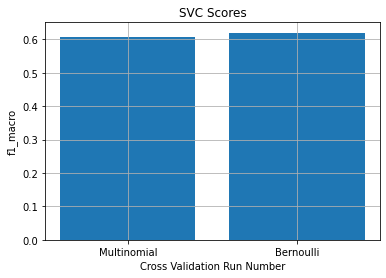

In [9]:
# To suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import Libraries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

# Feature Selection using Chi-squared and Mutual Information for top 100 features
X = feature_vectors
y = targets
X_chi2 = SelectKBest(chi2, k=100).fit_transform(X, y)
X_mutual = SelectKBest(mutual_info_classif, k=100).fit_transform(X, y)

# Calculate cross validation results for multinomial nb and bernoulli
mult_chi = cross_val_score(multinomial_clf, X_chi2, y, cv=5, scoring='f1_macro')
mult_mut = cross_val_score(multinomial_clf, X_mutual, y, cv=5, scoring='f1_macro')
bern_chi = cross_val_score(bernoulli_clf, X_chi2, y, cv=5, scoring='f1_macro')
bern_mut = cross_val_score(bernoulli_clf, X_mutual, y, cv=5, scoring='f1_macro')

# Prepare lists to be used for plotting
x_labels = ['Multinomial', 'Bernoulli']
y_chi = [mult_chi.mean(), bern_chi.mean()]
y_mut = [mult_mut.mean(), bern_mut.mean()]

# Plot results
plt.figure()
plt.bar(x_labels, y_chi)
plt.xlabel("Cross Validation Run Number")
plt.ylabel("f1_macro")
plt.title("SVC Scores")
plt.grid()
plt.show()

As seen from the plot, by using feature selection with k=100 top features it actually greatly damages Multinomial Naive Bayes from ~0.71 to ~0.61, yet it greatly bolsters Bernoulli NB by from ~0.43 to ~0.62. However, as of currently I would rather use the original Multinomial Naive Bayes as it's original score of 0.71 is still greater than the feature selected options.

However, in the following block I will explore further options in the case that there is in fact a better k number that will lead to a higher f1_macro score.

In [10]:
# Print original f1_macro scores of Multinomial and Bernoulli
print("Original Multinomial: " + str(mult_m))
print("Original Bernoulli: " + str(bern_m))

# Create a list of trial cases
k_amt = [100, 200, 500, 1000, 2000, 3000, 5000] 

# Create empty lists chi2 and mutual for both multinomial and bernoulli
mult_chi_list = []
mult_mut_list = []
bern_chi_list = []
bern_mut_list = []

# Repeat above process to calculate f1_macro scores
for i in k_amt:
    # Create feature selected vectors.
    X_chi2 = SelectKBest(chi2, k=i).fit_transform(X, y)
    X_mutual = SelectKBest(mutual_info_classif, k=i).fit_transform(X, y)

    # Calculate cross validation results for multinomial nb and bernoulli
    mult_chi = cross_val_score(multinomial_clf, X_chi2, y, cv=5, scoring='f1_macro')
    mult_mut = cross_val_score(multinomial_clf, X_mutual, y, cv=5, scoring='f1_macro')
    bern_chi = cross_val_score(bernoulli_clf, X_chi2, y, cv=5, scoring='f1_macro')
    bern_mut = cross_val_score(bernoulli_clf, X_mutual, y, cv=5, scoring='f1_macro')
    
    # Append score means to their respective lists
    mult_chi_list.append(mult_chi.mean())
    mult_mut_list.append(mult_mut.mean())
    bern_chi_list.append(bern_chi.mean())
    bern_mut_list.append(bern_mut.mean())
    
# Using the lists, find the max values and k_val at that max value. 
# Print Results
max_index = mult_chi_list.index(max(mult_chi_list)) # Finding index of max value
print("Multinomial Chi2: Max="+str(max(mult_chi_list))+" at k="+str(k_amt[max_index]))

max_index = mult_mut_list.index(max(mult_mut_list)) # Finding index of max value
print("Multinomial Mutual: Max="+str(max(mult_mut_list))+" at k="+str(k_amt[max_index]))

max_index = bern_chi_list.index(max(bern_chi_list)) # Finding index of max value
print("Bernoulli Chi2: Max="+str(max(bern_chi_list))+" at k="+str(k_amt[max_index]))

max_index = bern_mut_list.index(max(bern_mut_list)) # Finding index of max value
print("Bernoulli Mutual: Max="+str(max(bern_mut_list))+" at k="+str(k_amt[max_index]))


Original Multinomial: 0.7049591929687018
Original Bernoulli: 0.4283408206107861
Multinomial Chi2: Max=0.7503153217095717 at k=3000
Multinomial Mutual: Max=0.7318867768526077 at k=2000
Bernoulli Chi2: Max=0.658507780073404 at k=200
Bernoulli Mutual: Max=0.6082277928726879 at k=2000


Based on these results, I can say that Multinomial Chi2 is the best approach for the next set of tasks moving forward. As seen from the results above, Multinomial Chi2 has the highest f1_macro score at 0.7503 with a Chi2 feature selected approach with top 3000 features.

## Task 2: Validating Document Clustering Methods

#### Task 2.1: Normalize Vector Length

In [11]:
# Recreate feature selected feature_vector using Chi2 at k=3000
feature_selected_vectors = SelectKBest(chi2, k=3000).fit_transform(X, y)

# Identify original sparse dataset format, shape, and data type
print(feature_selected_vectors.getformat())
print(feature_selected_vectors.shape)
feature_selected_vectors

csr
(2000, 3000)


<2000x3000 sparse matrix of type '<class 'numpy.float64'>'
	with 69416 stored elements in Compressed Sparse Row format>

In [12]:
# Initialize new empty sparse dataset to fill with new calculated values
final_X = csr_matrix((2000, 3000), dtype=np.float64)

# Normalize vector length using scipy
for i in range(2000): # Loop through all 2000 rows
    # Calculate normalized vector and place into final_X matrix
    final_X[i,:] = feature_selected_vectors[i,:] / scipy.sparse.linalg.norm(feature_selected_vectors[i,:])

# Also create a dense version of final_X for clustering step
final_X_dense = final_X.toarray()

# Uncomment below to visualize new sparse dataset
# print(final_X)

#### Task 2.2: Try Clustering

In [13]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics

# Create a function to generate cluster labels as this will be a repeated
# process to get cluster labels
def generate_cluster_labels(num_cluster):
    kmeans_model = KMeans(n_clusters=num_cluster).fit(final_X)
    kmeans_clustering_labels = kmeans_model.labels_

    single_link_model = AgglomerativeClustering(n_clusters=num_cluster, linkage='ward'
                                           ).fit(final_X_dense)
    agglom_clustering_labels = single_link_model.labels_
    return kmeans_clustering_labels, agglom_clustering_labels

# Instantiate variables to hold metrics and n_cluster numbers used
n_c = list(range(2, 21)) # Number of clusters
kmeans_sc = [] # KMeans scores
kmeans_nmi = []
agg_sc = [] # Agglomerated scores
agg_nmi = []

# Using a loop through n_cluster, get scores and record to respective lists
for i in range(2, 21): # Loop from n_cluster 2 to 20
    # Generate cluster labels to be used in score calculation
    kmeans_cl_label, agg_cl_label = generate_cluster_labels(i)
    
    # Calculate scores and store data to list
    kmeans_sc.append(
        metrics.silhouette_score(final_X, kmeans_cl_label, metric='euclidean'))
    kmeans_nmi.append(
        metrics.normalized_mutual_info_score(targets, kmeans_cl_label))
    agg_sc.append(
        metrics.silhouette_score(final_X_dense, agg_cl_label, metric='euclidean'))
    agg_nmi.append(
        metrics.normalized_mutual_info_score(targets, agg_cl_label))
    

Text(0.5, 1.0, 'Plot of NMI Score vs. n_neighbors')

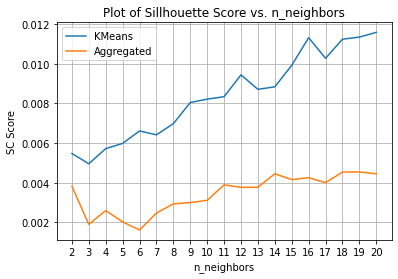

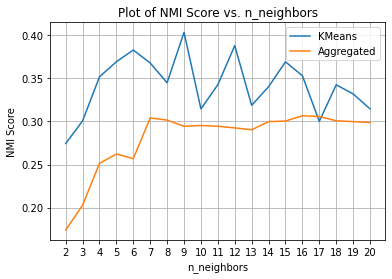

In [14]:
# Plotting both metrics and clustering models
# For Sillhouette Score
plt.figure()
plt.plot(n_c, kmeans_sc, label='KMeans')
plt.plot(n_c, agg_sc, label='Aggregated')
plt.legend()
plt.grid()
plt.xticks(n_c)
plt.xlabel ("n_neighbors")
plt.ylabel ("SC Score")
plt.title('Plot of Sillhouette Score vs. n_neighbors')

# For NMI Score
plt.figure()
plt.plot(n_c, kmeans_nmi, label='KMeans')
plt.plot(n_c, agg_nmi, label='Aggregated')
plt.legend()
plt.grid()
plt.xticks(n_c)
plt.xlabel ("n_neighbors")
plt.ylabel ("NMI Score")
plt.title('Plot of NMI Score vs. n_neighbors')

As seen from the results, we can see that KMeans has outscored Aggregated clustering for both metrics regardless of the number of neighbors.

Furthermore, we can note that both clustering methods result in a much lower Sillhouette score as compared to the NMI scores, with both KMeans and Aggregated having Sillhouette scores mostly lower than 0.01.

Another thing to note is that as n_neighbors increases, the Sillhouette score has an upward trend for KMeans. Meanwhile, the Aggregate Silhouette score seems to decrease until n_neighbors=6 and then increases just about to it's original position which may suggest that changes to n_neighbors may harm the model more than for Aggregated.

Regarding the NMI Score, Aggregated seems to follow a logarithmic trend in which as n_neighbors increases, the NMI score increases up until a certain point. For KMeans, the NMI score follows a more unstable pattern if sharply increasing and decreasing, but the score always staying relatively in the same spot as n_neighbors increases.

Moving forward, the scores seem to suggest that the model should continue using KMeans with an n_neighbors of 6 (according to the NMI plot), or 20 (according to the Sillhouette Plot).